In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 50000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(strip_unit=8*4, verbose=1):
  tree = load_pgun()
  
  outs = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    #print "ievt {0} nhits {1}".format(ievt, len(evt.hits))
    #print "..", sector_cnt_array
    #print "..", sector_cnt_array[best_sector]
    #print "..", sector_phi_array[best_sector]
    
    phis = sector_phi_array[best_sector]
    bins = np.arange(0, 4928, strip_unit)
    binned_phis = np.digitize(phis, bins=bins)
    binned_phis = np.unique(binned_phis, return_counts=True)
    best_bin = np.argmax(binned_phis[1])
    best_bin_cnt = binned_phis[1][best_bin]
    #print best_bin_cnt, len(phis), binned_phis
    
    passed = float(best_bin_cnt)/len(phis) > 6./8
    outs.append((part.pt, passed))

  return np.asarray(outs)

In [5]:
#eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30.)
edges = np.asarray(eff_pt_bins)

def post_analysis(outs):
  xdata = (edges[1:] + edges[:-1])/2

  denom = np.zeros_like(xdata, dtype=np.float32)
  numer = np.zeros_like(xdata, dtype=np.float32)

  for o in outs:
    x = np.digitize(o[0], bins=eff_pt_bins[1:])  # skip lowest edge
    if x == len(xdata):
      x -= 1
    denom[x] += 1
    if o[1]:
      numer[x] += 1

  denom[denom == 0] = 1
  ydata = np.true_divide(numer, denom)
  return xdata, ydata

In [6]:
strip_unit = 8*128
outs = analysis(strip_unit=strip_unit)
xdata, ydata = post_analysis(outs)

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processin

In [7]:
print strip_unit
print outs
print xdata, ydata

1024
[[ 2.49785972  1.        ]
 [ 2.50455952  1.        ]
 [16.77152443  1.        ]
 ...
 [ 4.90529919  1.        ]
 [23.55018806  1.        ]
 [18.99809837  1.        ]]
[ 0.25  0.75  1.25  1.75  2.5   3.5   4.5   5.5   6.5   7.5   9.   11.
 13.   15.   17.   19.   21.   23.   25.5  28.5 ] [0.         0.         0.         0.         0.72735506 0.8187604
 0.8520229  0.88548386 0.905007   0.9105392  0.93562806 0.9445483
 0.94654375 0.9618227  0.96884274 0.97307694 0.9581281  0.96385545
 0.96683675 0.98339874]


Using strip_unit 16
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 32
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 64
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 128
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 256
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 512
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 1024
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 2048
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root
Using strip_unit 5120
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.5.root


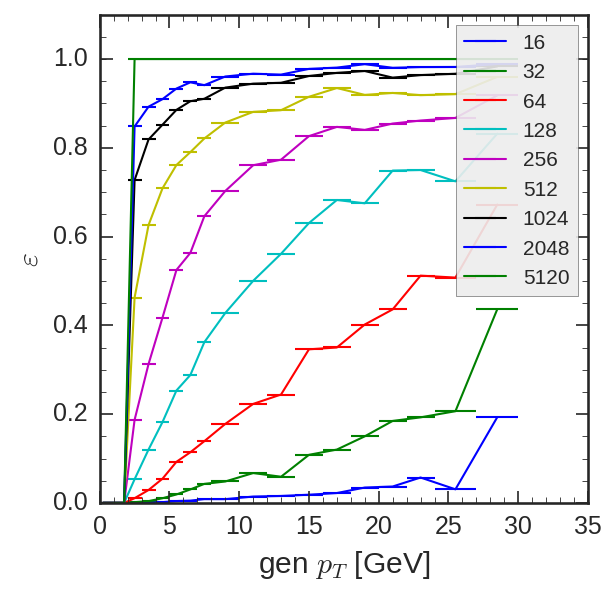

In [8]:
plt.style.use('tdrstyle.mplstyle')
plt.figure()

strip_units = [8*2, 8*4, 8*8, 8*16, 8*32, 8*64, 8*128, 8*256, 5120]

for strip_unit in strip_units:
  print('Using strip_unit {0}'.format(strip_unit))
  outs = analysis(strip_unit=strip_unit, verbose=0)
  xdata, ydata = post_analysis(outs)
  xerr = (edges[1:] - edges[:-1])/2
  #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
  plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

leg = plt.legend(strip_units, frameon=True, framealpha=0.9, fontsize=10)
leg.get_frame().set_facecolor('#ededed')
plt.xlim(0,35)
plt.ylim(0,1.1)
plt.xlabel(r'gen $p_{T}$ [GeV]')
plt.ylabel(r'$\varepsilon$')
plt.show()